# Projeto 1 - Ciência dos Dados

Nome: Augusto Ferreira

Nome: Diogo Diniz

Nome: João Andrade

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [25]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [26]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\zTodoresto\Insper\Projeto1Cdados\cdados-p1


Carregando a base de dados com os tweets classificados manualmente:

In [27]:
train = pd.read_excel('dados_treino.xlsx')
train.head(5)

,Mensagem,Unnamed: 1
0,Eu esperava um livro mais profundo pelas altas...,Negativo
1,Gostei muito do livro. Prende a nossa atenção ...,Positivo
2,"Intediante, chato, o livro fica por dizer cois...",Negativo
3,Trilogia perfeita!!!!!!!! Recomendo!!!! Melhor...,Positivo
4,"Comprei para presentear, então não posso avali...",Irrelevante


In [28]:
test = pd.read_excel('dados_teste.xlsx')
test.head(5)

,Mensagem,Unnamed: 1
0,Solicitei meu pagamento em 4 x e quando fui ve...,irrelevante
1,Tradução péssima!!! Os editores e o tradutor d...,irrelevante
2,"Peço que verifiquem e reparem este erro, acred...",irrelevante
3,Queria comprar a coleção... Aí fui antes numa ...,irrelevante
4,Comprei os boxes pela primeira vez e o produto...,irrelevante


___
## Classificador automático


Faça aqui uma descrição do seu assunto e o que considerou como relevante ou não relevante na classificação dos tweets (Target).

Foram considerados relevantes as informações que traziam comentários positivos ou negativos sobre o livro em si, e foram desconsiderados aqueles que falavam sobre problemas com a entrega, com o modelo digital, sobre preços e pagamentos.

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [29]:
def limpa_texto(texto):
    caractere_especial = ['', '!', '@', '¨', '#', '$',  '%', '&', '*', '?', '"',',','.']
    texto_limpo = ''
    for letra in texto:
        if letra not in  caractere_especial:
            letra_nova = letra.lower()
            texto_limpo += letra_nova
    return texto_limpo

test.columns = ['comentario','tag']
test['comentario'] = test['comentario'].apply(limpa_texto)
test['tag'] = test['tag'].apply(limpa_texto)
test['tag'].value_counts()

train.columns = ['comentario','tag']
train['comentario'] = train['comentario'].apply(limpa_texto)
train['tag'] = train['tag'].apply(limpa_texto)
train['tag'].value_counts()

negativo       331
irrelevante    135
positivo        34
Name: tag, dtype: int64

In [30]:
import math 
def separador_palavras(dt,tag):
    k=0
    texto=''

    if tag == 'positivo' or tag == 'negativo' or tag == 'irrelevante':
        frases= dt[dt['tag'] == tag]['comentario']
        for i in frases:
            texto += i
    else:
        while k < len(dt['comentario']):
            texto += dt['comentario'][k]

            k+=1

    return pd.Series(texto.split()).value_counts(True)

# Separando e achando a ocorrência de cada palavra no DataFrame Teste(train)
palavras = separador_palavras(train,'sem')
palavra_negativa = separador_palavras(train,'negativo')
palavra_positiva = separador_palavras(train,'positivo')
palavra_irrelevante = separador_palavras(train,'irrelevante')

# Achando o número de palavras de cada classificação 
numero_palavras_irrelevantes = len(palavra_irrelevante)
numero_palavras_positivas = len(palavra_positiva)
numero_palavras_negativas = len(palavra_negativa)
total_palavras = numero_palavras_irrelevantes + numero_palavras_negativas + numero_palavras_positivas

#Calculando a probabilidade de cada classificação 
probabilidade_negativa = numero_palavras_negativas/total_palavras
probabilidade_positiva = numero_palavras_positivas/total_palavras
probabilidade_irrelevante = numero_palavras_irrelevantes/total_palavras

def calcula_probabilidade(tag, comentario):
    # Probabilidade condicional da frase dada a categoria
    prob_condicional = 1.0

    # Calcula a probabilidade condicional multiplicando as probabilidades das palavras na frase
    for palavra in comentario.split():
        if tag == 'negativo':
            prob_condicional *= palavra_negativa.get(palavra, 1 / (total_palavras + 1))  # Suavização de Laplace
        elif tag == 'positivo':
            prob_condicional *= palavra_positiva.get(palavra, 1 / (total_palavras + 1))  # Suavização de Laplace
        elif tag == 'irrelevante':
            prob_condicional *= palavra_irrelevante.get(palavra, 1 / (total_palavras + 1))  # Suavização de Laplace

    # Probabilidade a priori da categoria
    if tag == 'negativo':
        prob_a_priori = probabilidade_negativa
    elif tag == 'positivo':
        prob_a_priori = probabilidade_positiva
    elif tag == 'irrelevante':
        prob_a_priori = probabilidade_irrelevante

    # Calcula a probabilidade final
    probabilidade = prob_condicional * prob_a_priori

    return probabilidade


___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [31]:
#Contador de acertos (verdadeiros)
acertos_positivo = 0
acertos_negativo = 0
acertos_irrelevante = 0

#Contador de erros (falsos)
erros_positivo = 0
erros_irrelevante = 0
erros_negativo = 0

for comentario, categoria_real in zip(test['comentario'], test['tag']):
    # Use a função calcula_probabilidade para determinar a categoria
    prob_negativa = calcula_probabilidade('negativo', comentario)
    prob_positiva = calcula_probabilidade('positivo', comentario)
    prob_irrelevante = calcula_probabilidade('irrelevante', comentario)

    # Categoria de maior probabilidade
    if prob_negativa >= prob_positiva and prob_negativa >= prob_irrelevante:
        categoria_predita = 'negativo'
    elif prob_positiva >= prob_negativa and prob_positiva >= prob_irrelevante:
        categoria_predita = 'positivo'
    else:
        categoria_predita = 'irrelevante'

    # Atualizar acertos
    if categoria_predita == categoria_real:
        if categoria_real == 'positivo':
            acertos_positivo += 1
        elif categoria_real == 'negativo':
            acertos_negativo += 1
        elif categoria_real == 'irrelevante':
            acertos_irrelevante += 1
    
    # Contar Erros
    if categoria_predita != categoria_real:
        if categoria_real == 'positivo':
            erros_positivo += 1
        elif categoria_real == 'negativo':
            erros_negativo += 1
        elif categoria_real == 'irrelevante':
            erros_irrelevante += 1
            

# total de comentários para cada categoria
total_positivo = len(test[test['tag'] == 'positivo'])
total_negativo = len(test[test['tag'] == 'negativo'])
total_irrelevante = len(test[test['tag'] == 'irrelevante'])
total =total_irrelevante +total_negativo+total_positivo


# Taxas de vrdadeiras
verdadeiro_positivo = acertos_positivo / total_positivo
verdadeiro_negativo = acertos_negativo / total_negativo
verdadeiro_irrelevante = acertos_irrelevante / total_irrelevante

# Taxas de falsos

falso_irrelevante = erros_irrelevante / total_irrelevante
falso_negativo = erros_negativo / total_negativo
falso_positivo = erros_positivo / total_positivo

# Tabela de verdadeiros e Falsos

tabela_verdadeiros_falsos = pd.DataFrame({'Verdadeiro Positivo':[acertos_positivo/total],'Falso Positivo':[erros_positivo/total],
'Verdadeiro Negativo': [acertos_negativo/total],'Falso Negativo':[erros_negativo/total],'Verdadeiro Irrelevante':[acertos_irrelevante/total],'Falso Irrelevante':
[erros_irrelevante/total]})



# Calcular taxa de eficácia de Positivo , Negativo e Irrelevante

eficacia_positivo = (verdadeiro_positivo/(verdadeiro_positivo+falso_positivo))*100
eficacia_negativo = (verdadeiro_negativo/(verdadeiro_negativo+falso_positivo))*100
eficacia_irrelevante = (verdadeiro_irrelevante/(verdadeiro_irrelevante+falso_irrelevante))*100

print(f'A taxa de acerto do classificador quando o comentário é positivo é {eficacia_positivo:.2f}%')
print(f'A taxa de acerto do classificador quando o comentário é negativo é {eficacia_negativo:.2f}%')
print(f'A taxa de acerto do classificador quando o comentário é irrelevante é {eficacia_irrelevante:.2f}%')

acuracia = ((verdadeiro_positivo + verdadeiro_negativo + verdadeiro_irrelevante) / (verdadeiro_positivo + verdadeiro_negativo + verdadeiro_irrelevante + falso_irrelevante +falso_negativo
+falso_positivo))*100

print(f'a acuracia é de {acuracia:.2f}%')

tabela_verdadeiros_falsos


A taxa de acerto do classificador quando o comentário é positivo é 33.33%
A taxa de acerto do classificador quando o comentário é negativo é 45.55%
A taxa de acerto do classificador quando o comentário é irrelevante é 85.37%
a acuracia é de 58.16%


,Verdadeiro Positivo,Falso Positivo,Verdadeiro Negativo,Falso Negativo,Verdadeiro Irrelevante,Falso Irrelevante
0,0.016,0.032,0.348,0.276,0.28,0.048


'positivo'

___
### Concluindo

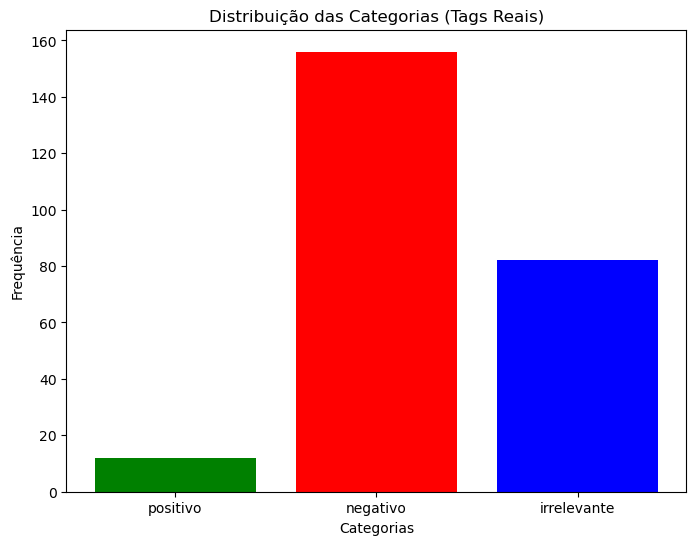

In [44]:
tags_reais = test['tag'].tolist()
categorias = ['positivo', 'negativo', 'irrelevante']
frequencia = [tags_reais.count('positivo'), tags_reais.count('negativo'), tags_reais.count('irrelevante')]

plt.figure(figsize=(8, 6))
plt.bar(categorias, frequencia, color=['green', 'red', 'blue'])
plt.xlabel('Categorias')
plt.ylabel('Frequência')
plt.title('Distribuição das Categorias (Tags Reais)')
plt.show()


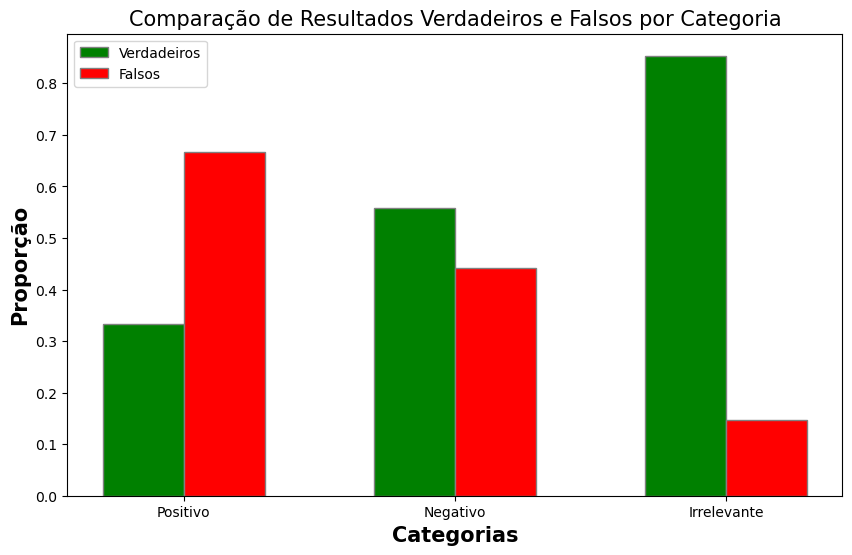

In [46]:
verdadeiros = [verdadeiro_positivo, verdadeiro_negativo, verdadeiro_irrelevante]
falsos = [falso_positivo, falso_negativo, falso_irrelevante]
categorias = ['Positivo', 'Negativo', 'Irrelevante']


plt.figure(figsize=(10, 6))
barWidth = 0.3

r1 = range(len(verdadeiros))
r2 = [x + barWidth for x in r1]
 

plt.bar(r1, verdadeiros, color='green', width=barWidth, edgecolor='grey', label='Verdadeiros')
plt.bar(r2, falsos, color='red', width=barWidth, edgecolor='grey', label='Falsos')

plt.xlabel('Categorias', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth/2 for r in range(len(verdadeiros))], categorias)
plt.ylabel('Proporção', fontweight='bold', fontsize=15)
plt.title('Comparação de Resultados Verdadeiros e Falsos por Categoria', fontsize=15)
plt.legend()
plt.show()

Considerando as taxas de acerto diferentes para cada categoria, nota-se que a precisão do modelo varia consideravelmente. Enquanto a categoria "irrelevante" possui uma taxa de acerto notavelmente alta de 85.4%, as categorias "positivo" e "negativo" apresentam acurácias consideravelmente baixas, evidenciando a necessidade de melhorias significativas para aumentar a precisão nessas áreas.

Lidar com nuances linguísticas como sarcasmo e dupla negação é um desafio para modelos de Machine Learning, especialmente para abordagens mais simples como o Naive Bayes. Estas nuances frequentemente requerem uma compreensão profunda do contexto e do tom, o que é complexo para modelos tradicionais de Machine Learning. Portanto, aprimorar o entendimento do modelo sobre esses contextos exigiria técnicas mais avançadas e refinadas.

Portanto, enquanto o modelo atual demonstra eficácia em identificar mensagens irrelevantes, melhorar a precisão nas categorias "positivo" e "negativo" demandaria técnicas mais sofisticadas, especialmente para lidar com figuras de linguagem complexas como sarcasmo e dupla negação.

Adotando técnicas avançadas como Deep Learning, o projeto tem o potencial de elevar significativamente a precisão do classificador. Ao compreender as nuances do idioma de maneira mais sofisticada, especialmente em relação a figuras de linguagem como sarcasmo e dupla negação, os modelos baseados em Deep Learning são capazes de oferecer interpretações mais precisas e contextuais. Esse aprimoramento não apenas impulsionaria a eficácia do classificador, mas também expandiria seu alcance para diversas aplicações práticas. Portanto, o investimento contínuo no projeto, especialmente na implementação de técnicas avançadas como Deep Learning, é crucial para maximizar sua eficácia e relevância no cenário da análise de texto.

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

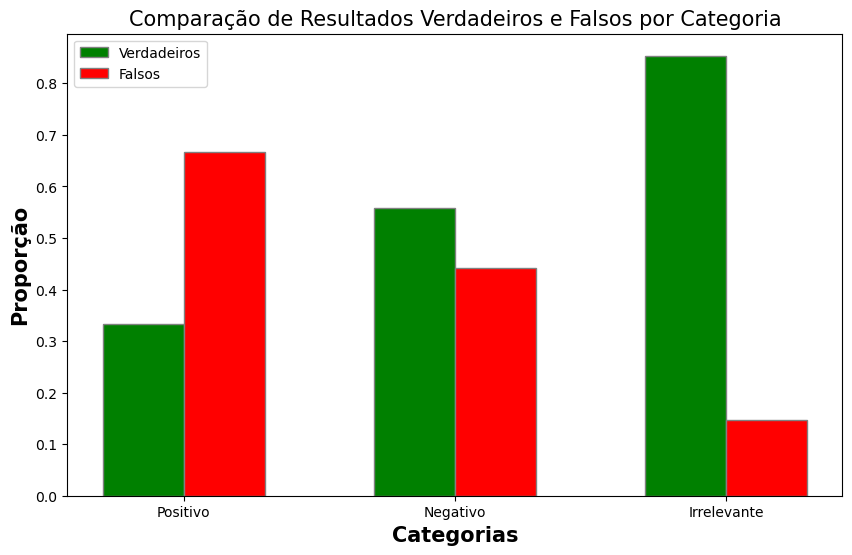

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CONSIDEROU mais de duas categorias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por categoria (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**